In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *


In [2]:
def post_process2(df_raw):
    # df for monte carlo plots
    last_substep = max(df_raw.substep)

    df_p = df_raw.copy()
    df_p = df_p[df_p.substep == last_substep]
    df_p['ve_balance'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].vebalance for acct in x['ve_accounts'].keys()]), axis=1)
    df_p['locked_supply'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].locked for acct in x['ve_accounts'].keys()]), axis=1)
    #df_p['lock_duration_sum'] = df_p.groupby('run').apply(lambda x: sum([x['ve_accounts'][acct].lockduration for acct in x['ve_accounts'].keys()]), axis=1)
    #df_p['lock_duration_diff'] = df_p.groupby('run').diff()['lock_duration_sum']
    df_p['active_pct'] = df_p.apply(lambda x: sum([x['votes'][asset] for asset in x['votes'].keys()]), axis=1)
    df_p['pct_locked'] = df_p['locked_supply'] / (df_p['locked_supply'] + df_p['ocean_unlocked_supply'])
    df_p['dcv'] = df_p.apply(lambda x: sum([x['data_assets'][asset].dataconsumevolume for asset in x['data_assets'].keys()]), axis=1)
    df_p['Passive_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['ve_balance']) ** 52 - 1 if x['ve_balance'] != 0 else 0, axis=1)
    df_p['Active_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['ve_balance'])) ** 52 - 1 if x['ve_balance'] != 0 and x['active_pct'] != 0 else 0, axis=1)
    df_p['Fees_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_fees']/x['ve_balance']) ** 52 - 1 if x['ve_balance'] != 0 else 0, axis=1)
    #df_p['Agg_APY'] = df_p.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
    #df_p['Agg_APY'] = df_p.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1) + x['Active_APY']*x['active_pct'] if x['locked_supply'] != 0 else 0, axis=1)
    df_p['Agg_APY'] = df_p.apply(lambda x: (x['Passive_APY'] + x['Fees_APY'] + x['Active_APY']*x['active_pct']), axis=1)

    df_p = df_p[['simulation', 'subset', 'timestep', 'ocean_treasury', 'ocean_unlocked_supply'
             , 'locked_supply', 'pct_locked', 've_balance', 'active_pct', 'dcv', 'rewards_distributed_df_passive'
             , 'rewards_distributed_df_active', 'rewards_distributed_fees', 'Passive_APY', 'Active_APY', 'Fees_APY'
             , 'Agg_APY']]

    return df_p

In [3]:
MONTE_CARLO_RUNS = 1
sim_length = 832 #CHANGE IN behavior_ve.py too!!!

In [4]:
# Batch params
system_params = create_par_sweep(system_params)
#psubs = generate_psubs_stoch()
psubs = generate_psubs_stoch_2()




psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch, Consumption: p_data_asset_consumed_stoch
psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch, Consumption: p_data_asset_consumed_stoch_2
psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch_2, Consumption: p_data_asset_consumed_stoch
psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch_2, Consumption: p_data_asset_consumed_stoch_2


In [36]:
system_params

{'minlock_amt': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0],
 'maxlock_amt': [5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  5000000.0,
  500000

In [5]:
param_batch_size = 2
param_batches = 36

#72*4 = 288 total (3*3*2*4)*4

assert param_batch_size*param_batches == len(system_params['minlock_amt'])

for i in range(3,len(psubs)):
    for j in range(param_batches_start, param_batches):
        
        system_params_batch = {}
        
        for key in system_params.keys():
            system_params_batch[key] = system_params[key][j*param_batch_size:(j+1)*param_batch_size]
        
        del configs[:]
        
        sim_config = config_sim({
            "N": MONTE_CARLO_RUNS,
            "T": range(sim_length),
            "M": system_params_batch
        })

        experiment.append_configs(
            initial_state = initial_state,
            partial_state_update_blocks = psubs[i],
            sim_configs = sim_config
        )

        exec_context = ExecutionContext()
        simulation = Executor(exec_context=exec_context, configs=configs)
        raw_result, tensor_field, sessions = simulation.execute()

        simulation_result = pd.DataFrame(raw_result)
        df_write_out = post_process2(simulation_result)
        df_write_out.to_csv('results/second_big_sim_parambatch_'+str(j)+'psubsbatch_'+str(i)+'.csv')



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 21, 2, 10)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 1]
Ns       : [0, 1]
ExpIDs   : [0, 0]
Execution Mode: parallelized
Total execution time: 349.83s


In [1]:
import pandas as pd
# import plotly
import matplotlib.pyplot as plt

In [7]:
simulation_result = pd.DataFrame()
file_prefix = 'first_big_sim_batch_'

batches = 90
batch_size = 3

for i in range(batches):
    df = pd.read_csv('results/' + file_prefix + str(i) + '.csv')
    df['subset'] = df['subset'] + i * batch_size

    simulation_result = pd.concat([simulation_result, df])
    
file_prefix = 'first_big_sim_batch_small_'
batches = 324
batches_start = 271
batch_size = 1

for i in range(batches_start, batches):
    df = pd.read_csv('results/' + file_prefix + str(i) + '.csv')
    df['subset'] = df['subset'] + i * batch_size

    simulation_result = pd.concat([simulation_result, df])

In [8]:
df_p = simulation_result.copy()

In [4]:
simulation_result = pd.DataFrame()
file_prefix = 'second_big_sim_parambatch_'

batches = 36
batch_size = 2
psub_count = 4

for i in range(psub_count):
    for j in range(batches):
        df = pd.read_csv('results/second_big_sim/' + file_prefix +str(j)+'psubsbatch_'+str(i)+'.csv')
        df['subset'] = df['subset'] + j * batch_size + batch_size * batches * i
        simulation_result = pd.concat([simulation_result, df])

In [5]:
df_p = simulation_result.copy()

In [6]:
import re
def extract_decimal(x):
    if type(x) == float:
        return x
    else:
        match = re.search(r'\d+\.\d+', x)
        if match:
            return float(match.group())
        else:
            return 0.0
    
df_p.active_pct = df_p.active_pct.apply(extract_decimal)
df_p.Active_APY = df_p.Active_APY.apply(extract_decimal)
df_p.Agg_APY = df_p.Agg_APY.apply(extract_decimal)

df_p

Unnamed: 0  simulation  subset  timestep  ocean_treasury   
0              4           0       0         1    5.033950e+08  \
1              8           0       0         2    5.033895e+08   
2             12           0       0         3    5.033837e+08   
3             16           0       0         4    5.033787e+08   
4             20           0       0         5    5.033716e+08   
...          ...         ...     ...       ...             ...   
1659        6641           0     287       828    1.370484e+08   
1660        6645           0     287       829    1.369065e+08   
1661        6649           0     287       830    1.367646e+08   
1662        6653           0     287       831    1.366228e+08   
1663        6657           0     287       832    1.364809e+08   

      ocean_unlocked_supply  locked_supply  pct_locked    ve_balance   
0              4.275692e+08   6.462588e+06    0.014890  2.220609e+06  \
1              4.254901e+08   8.547298e+06    0.019693  4.241665e+06   
2              4.171352e+08   1.690787e+07    0.038954  1.125651e+07   
3              4.092787e+08   2.476939e+07    0.057066  1.854342e+07   
4              4.064973e+08   2.755794e+07    0.063489  1.907432e+07   
...                     ...            ...         ...           ...   
1659           1.063307e+07   7.897453e+08    0.986715  5.998684e+08   
1660           1.063884e+07   7.898815e+08    0.986710  5.984350e+08   
1661           1.067492e+07   7.899873e+08    0.986667  5.987460e+08   
1662           1.063474e+07   7.901693e+08    0.986720  5.983019e+08   
1663           1.376133e+07   7.871846e+08    0.982819  5.956440e+08   

      active_pct           dcv  rewards_distributed_df_passive   
0       0.032653  0.000000e+00                          5000.0  \
1       0.364177  5.453480e+04                          5000.0   
2       0.005045  1.140030e+05                          5000.0   
3       0.000000  1.611381e+05                          5000.0   
4       0.079617  2.140090e+05                          5000.0   
...          ...           ...                             ...   
1659    0.601441  6.107326e+07                         70941.5   
1660    0.644212  6.098829e+07                         70941.5   
1661    0.623108  6.370782e+07                         70941.5   
1662    0.597556  6.311311e+07                         70941.5   
1663    0.612076  6.106372e+07                         70941.5   

      rewards_distributed_df_active  rewards_distributed_fees  Passive_APY   
0                          0.000000                  0.000000     0.124067  \
1                        541.764015                 27.267398     0.063176   
2                        734.074557                 57.001500     0.023361   
3                          0.000000                 80.569035     0.014118   
4                       2105.855018                107.004518     0.013722   
...                             ...                       ...          ...   
1659                   70941.500000              30536.629764     0.006168   
1660                   70941.500000              30494.145843     0.006183   
1661                   70941.500000              31853.909064     0.006180   
1662                   70941.500000              31556.556538     0.006184   
1663                   70941.500000              30531.860877     0.006212   

      Active_APY  Fees_APY   Agg_APY  
0       0.000000  0.000000  0.124067  
1       0.018402  0.000334  0.070212  
2       0.950108  0.000263  0.028418  
3       0.000000  0.000226  0.014344  
4       0.074716  0.000292  0.019963  
...          ...       ...       ...  
1659    0.010276  0.002651  0.014999  
1660    0.009614  0.002653  0.015030  
1661    0.009936  0.002770  0.015141  
1662    0.010371  0.002746  0.015128  
1663    0.010169  0.002669  0.015105  

[239616 rows x 18 columns]

In [7]:
simulation_result.groupby(['simulation', 'subset']).count()['timestep']

simulation  subset
0           0         832
            1         832
            2         832
            3         832
            4         832
                     ... 
            283       832
            284       832
            285       832
            286       832
            287       832
Name: timestep, Length: 288, dtype: int64

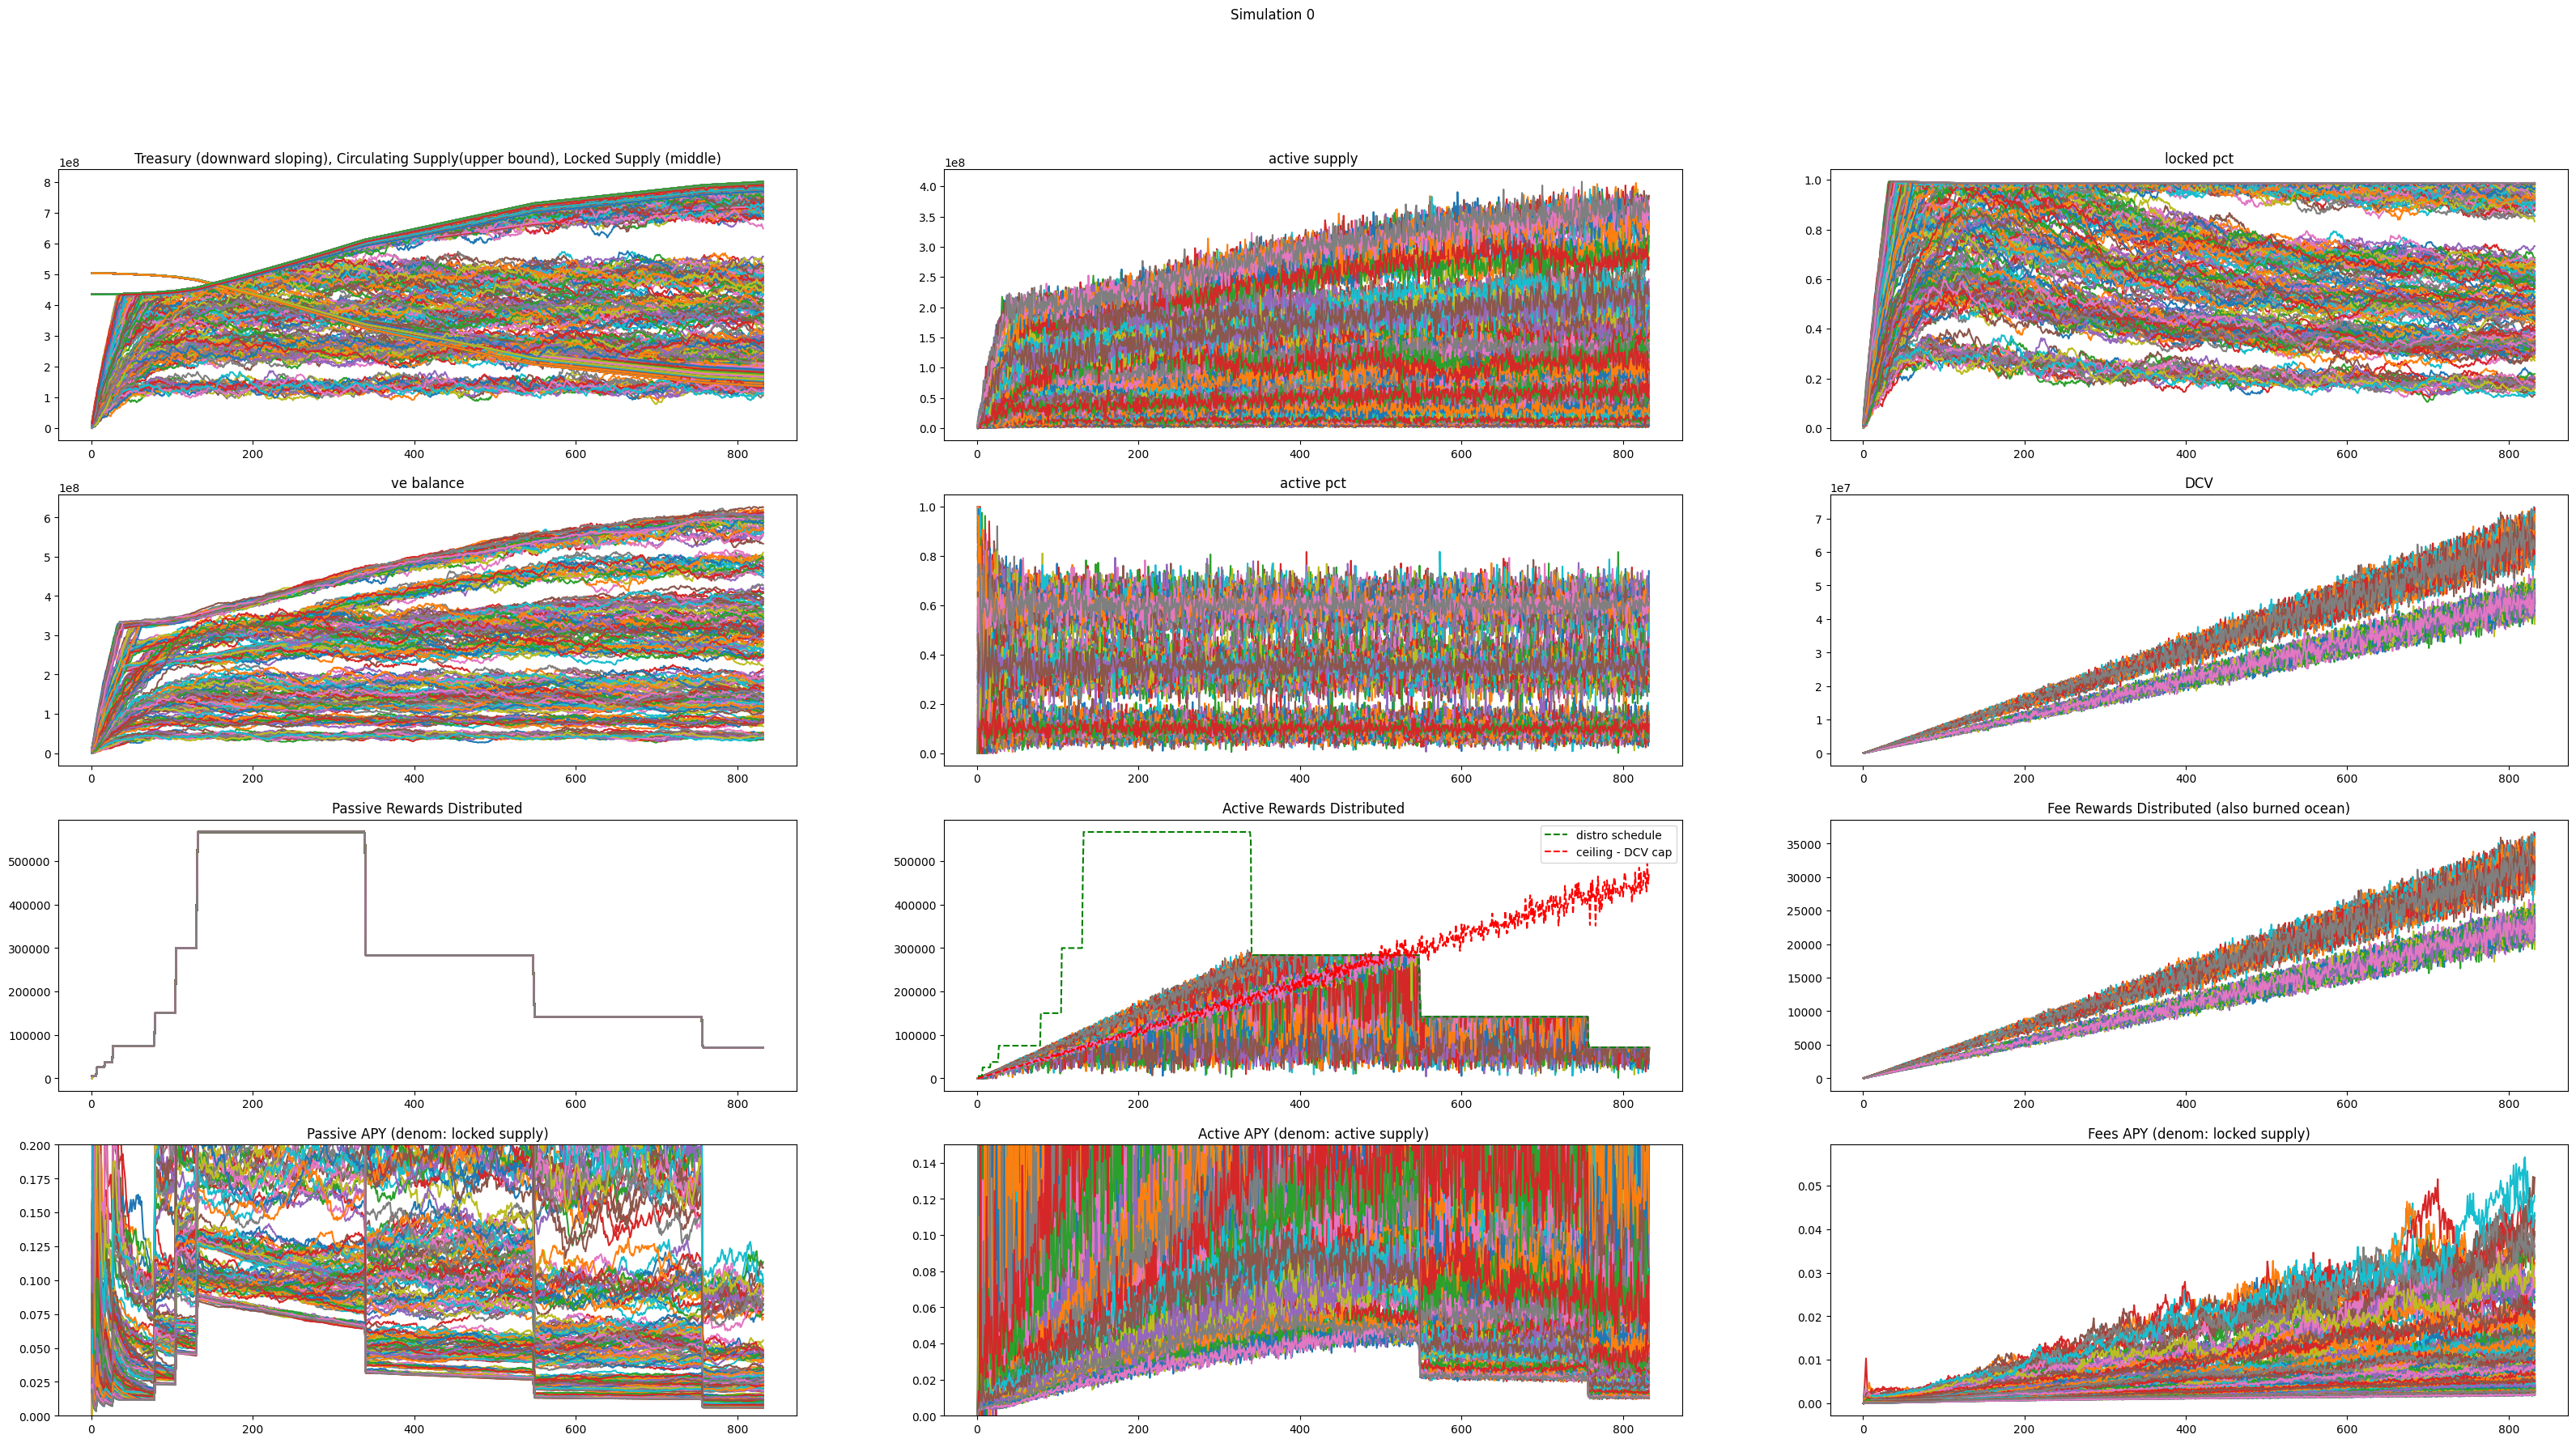

In [30]:
# plot monte carlo runs
for sim in range(0, max(df_p.simulation) + 1):
    df_tmp0 = df_p[df_p.simulation == sim]
    fig, ax = plt.subplots(4,3, figsize=(40,20))
    #for run in range(1, max(df_p.run)+1):
    #    df_tmp = df_tmp0[df_tmp0.run == run]
    for subset in range(0, max(df_p.subset)+1):
        df_tmp = df_tmp0[df_tmp0.subset == subset]
        ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_treasury)
        ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply + df_tmp.locked_supply)
        ax[0,0].plot(df_tmp.timestep, df_tmp.locked_supply)
        #ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply)
        ax[0,2].plot(df_tmp.timestep, df_tmp.pct_locked)
        ax[1,0].plot(df_tmp.timestep, df_tmp.ve_balance)
        # could plot avg lock duration??? # driver: locking behavior
        ax[1,1].plot(df_tmp.timestep, df_tmp.active_pct) # driver: voting behavior (uniform random)
        ax[0,1].plot(df_tmp.timestep, df_tmp.active_pct * df_tmp.ve_balance)
        # something for asset-level voting success / distribution # driver: voting behavior (uniform random)
        # x = sort by dataconsumevolume, y = pct of veocean allocated to asset
        ax[1,2].plot(df_tmp.timestep, df_tmp.dcv) # driver: DCV growth rate
        ax[2,0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive) # driver: distribution schedule
        ax[2,1].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active) # driver: distribution schedule & locking behavior & voting behavior (floor: 0% active or 0% voting success & middle: active_pct/voting success & asset-level success/distribution) & Rewards Function (ceiling: DCV*0.1 or 125%APY, therefore DCV growth rate)
        ax[2,2].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees) # driver: DCV growth rate
        ax[3,0].plot(df_tmp.timestep, df_tmp.Passive_APY) #driver: distro schedule & locking behavior
        ax[3,1].plot(df_tmp.timestep, df_tmp.Active_APY) #driver: distro schedule & locking behavior & voting behavior(active pct & asset-level voting success)
        ax[3,2].plot(df_tmp.timestep, df_tmp.Fees_APY) #driver: DCV growth rate & locking behavior
        #ax[3,3].plot(df_tmp.timestep, df_tmp.Agg_APY)
            
    #ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
    #ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')
    ax[2,1].plot(df_tmp0[df_tmp0.subset == 2].timestep, df_tmp0[df_tmp0.subset == 2].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
    ax[2,1].plot(df_tmp0[df_tmp0.subset == 2].timestep, df_tmp0[df_tmp0.subset == 2].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')
    
    ax[0,0].set_title('Treasury (downward sloping), Circulating Supply(upper bound), Locked Supply (middle)')
    ax[0,1].set_title('active supply')
    ax[0,2].set_title('locked pct')
    ax[1,0].set_title('ve balance')
    ax[1,1].set_title('active pct')
    #ax[1,2].set_title('something to show uniform random asset-level voting success / distribution')
    ax[1,2].set_title('DCV')
    ax[2,0].set_title('Passive Rewards Distributed')
    ax[2,1].set_title('Active Rewards Distributed')
    ax[2,2].set_title('Fee Rewards Distributed (also burned ocean)')
    ax[3,0].set_title('Passive APY (denom: locked supply)')
    ax[3,0].set_ylim(0,0.2)
    ax[3,1].set_title('Active APY (denom: active supply)')
    ax[3,1].set_ylim(0,0.15)
    ax[3,2].set_title('Fees APY (denom: locked supply)')
    #ax[3,3].set_title('Agg APY (denom: locked supply)')
    ax[2,1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

In [8]:
# df for avg monte carlo plots (avg APYs across all runs)
df_avg_apy = df_p[['simulation', 'subset', 'timestep', 'rewards_distributed_df_passive', 'rewards_distributed_df_active', 'rewards_distributed_fees', 'locked_supply', 'active_pct']].reset_index(drop=True)
df_avg_apy = df_avg_apy.groupby(['simulation', 'timestep']).mean().reset_index()
#df_avg_apy = df_avg_apy.groupby(['subset', 'timestep']).mean().reset_index()
df_avg_apy['avg_Agg_rewards_distributed'] = df_avg_apy['rewards_distributed_df_passive'] + df_avg_apy['rewards_distributed_df_active'] + df_avg_apy['rewards_distributed_fees']
df_avg_apy['avg_Passive_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Active_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_avg_apy['avg_Fees_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1) + x['avg_Active_APY']*x['active_pct'] if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (x['avg_Passive_APY'] + x['avg_Fees_APY'] + x['avg_Active_APY']*x['active_pct']), axis=1)


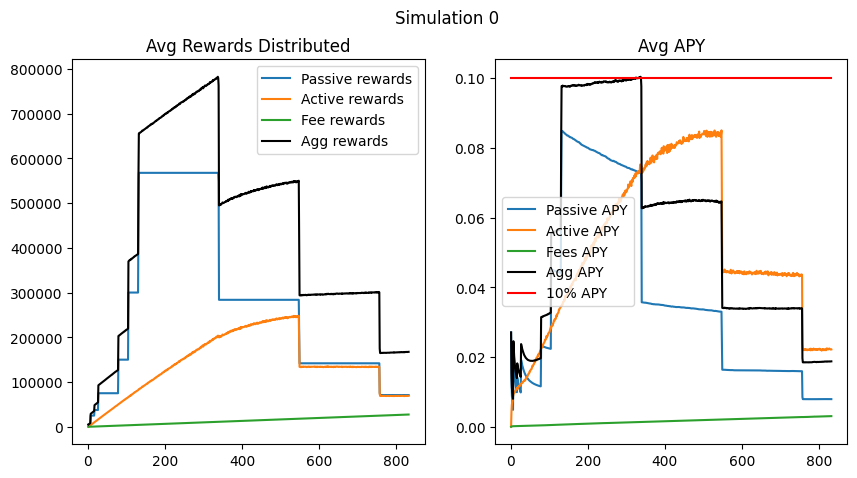

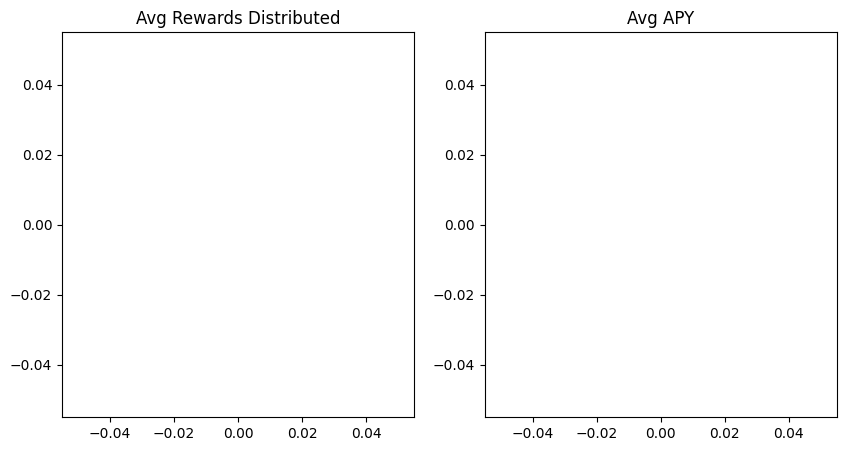

In [34]:
def f(x):
    return x-x+0.1 

weeks = 4

for sim in range(0, max(df_p.simulation) + 1):
    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
#for subset in range(0, max(df_p.subset)+1):
#    df_tmp = df_avg_apy[df_avg_apy.subset == subset]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #ax[0].plot(df_avg_apy.timestep, df_avg_apy.locked_supply, label='Locked Supply')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive, label='Passive rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active, label='Active rewards')
    #ax[0].plot(df_tmp.timestep, get_rolling_avg(df_tmp.rewards_distributed_df_active, weeks), label='1m avg - Active rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees, label='Fee rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label='Agg rewards', color='black')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Passive_APY, label='Passive APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Active_APY, label='Active APY')
    #ax[1].plot(df_tmp.timestep, get_rolling_avg(df_tmp.avg_Active_APY, weeks), label='1m avg - Active APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Fees_APY, label='Fees APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label='Agg APY', color='black')
    ax[1].plot(df_tmp.timestep, f(df_tmp.timestep), label='10% APY', color='red')
    ax[0].set_title('Avg Rewards Distributed')
    ax[1].set_title('Avg APY')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
#for sim in range(0, max(df_p.simulation) + 1):
#    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
for subset in range(0, max(df_p.subset)+1):
    df_tmp = df_avg_apy[df_avg_apy.subset == subset]
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label=f'sim{sim} Agg rewards')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label=f'sim{sim} Agg APY')
ax[0].set_title('Avg Rewards Distributed')
ax[1].set_title('Avg APY')
#ax[0].legend()
#ax[1].legend()
plt.show()
